# Step 1 : Importing Essetial Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step 2 : Importing Data and Creating a Dataframe

In [2]:
import os
import pandas as pd

# Directories containing the training and test datasets
train_dir = '/kaggle/input/isic-dataset-inpaint-applied/Applied Inpainting'

# Initialize an empty DataFrame to store image paths and labels
df = pd.DataFrame(columns=['image_path', 'label'])

# Populate the DataFrame with image paths and corresponding labels from the training set
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        df = df.append({'image_path': image_path, 'label': label}, ignore_index=True)

df


,image_path,label
0,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
2,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
3,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
4,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
...,...,...
2234,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2235,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2236,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
2237,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8


In [3]:
# Get list of directories in train_dir
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

# Step 3 : EDA

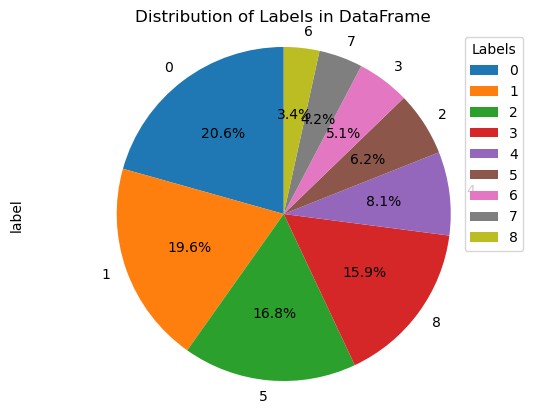

In [4]:
import matplotlib.pyplot as plt

# Plot a pie chart showing the distribution of labels in the DataFrame
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)

# Ensure the pie chart is a circle (equal aspect ratio)
plt.axis('equal')

# Add a title to the chart
plt.title('Distribution of Labels in DataFrame')

# Add a legend using unique labels
plt.legend(labels=df['label'].unique(), title="Labels")

# Display the plot
plt.show()


In [5]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)  # Separator line for the summary table header
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")  # Table header with aligned columns
print("-" * 60)  # Separator line between header and data

# Iterate through label_map and print the count of images for each class
for class_label, class_name in label_map.items():
    count = class_counts[class_label]  # Get the count of images for the current class label
    print(f"{class_label:<15} {class_name:<30} {count:<10}")  # Print class label, class name, and count

print("-" * 60)  # Separator line after data rows
print(f"{'Total':<45} {sum(class_counts):<10}")  # Print the total number of images across all classes


Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     462       
1               melanoma                       438       
2               vascular lesion                139       
3               actinic keratosis              114       
4               squamous cell carcinoma        181       
5               basal cell carcinoma           376       
6               seborrheic keratosis           77        
7               dermatofibroma                 95        
8               nevus                          357       
------------------------------------------------------------
Total                                         2239      


# Step 4 : Loading and resizing of images

In [6]:
max_images_per_class = 3000  # Define the maximum number of images to keep for each class

# Group by the 'label' column and take the first 'max_images_per_class' rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [7]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [8]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

4

**Image Resizeing**

In [9]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((128,128)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

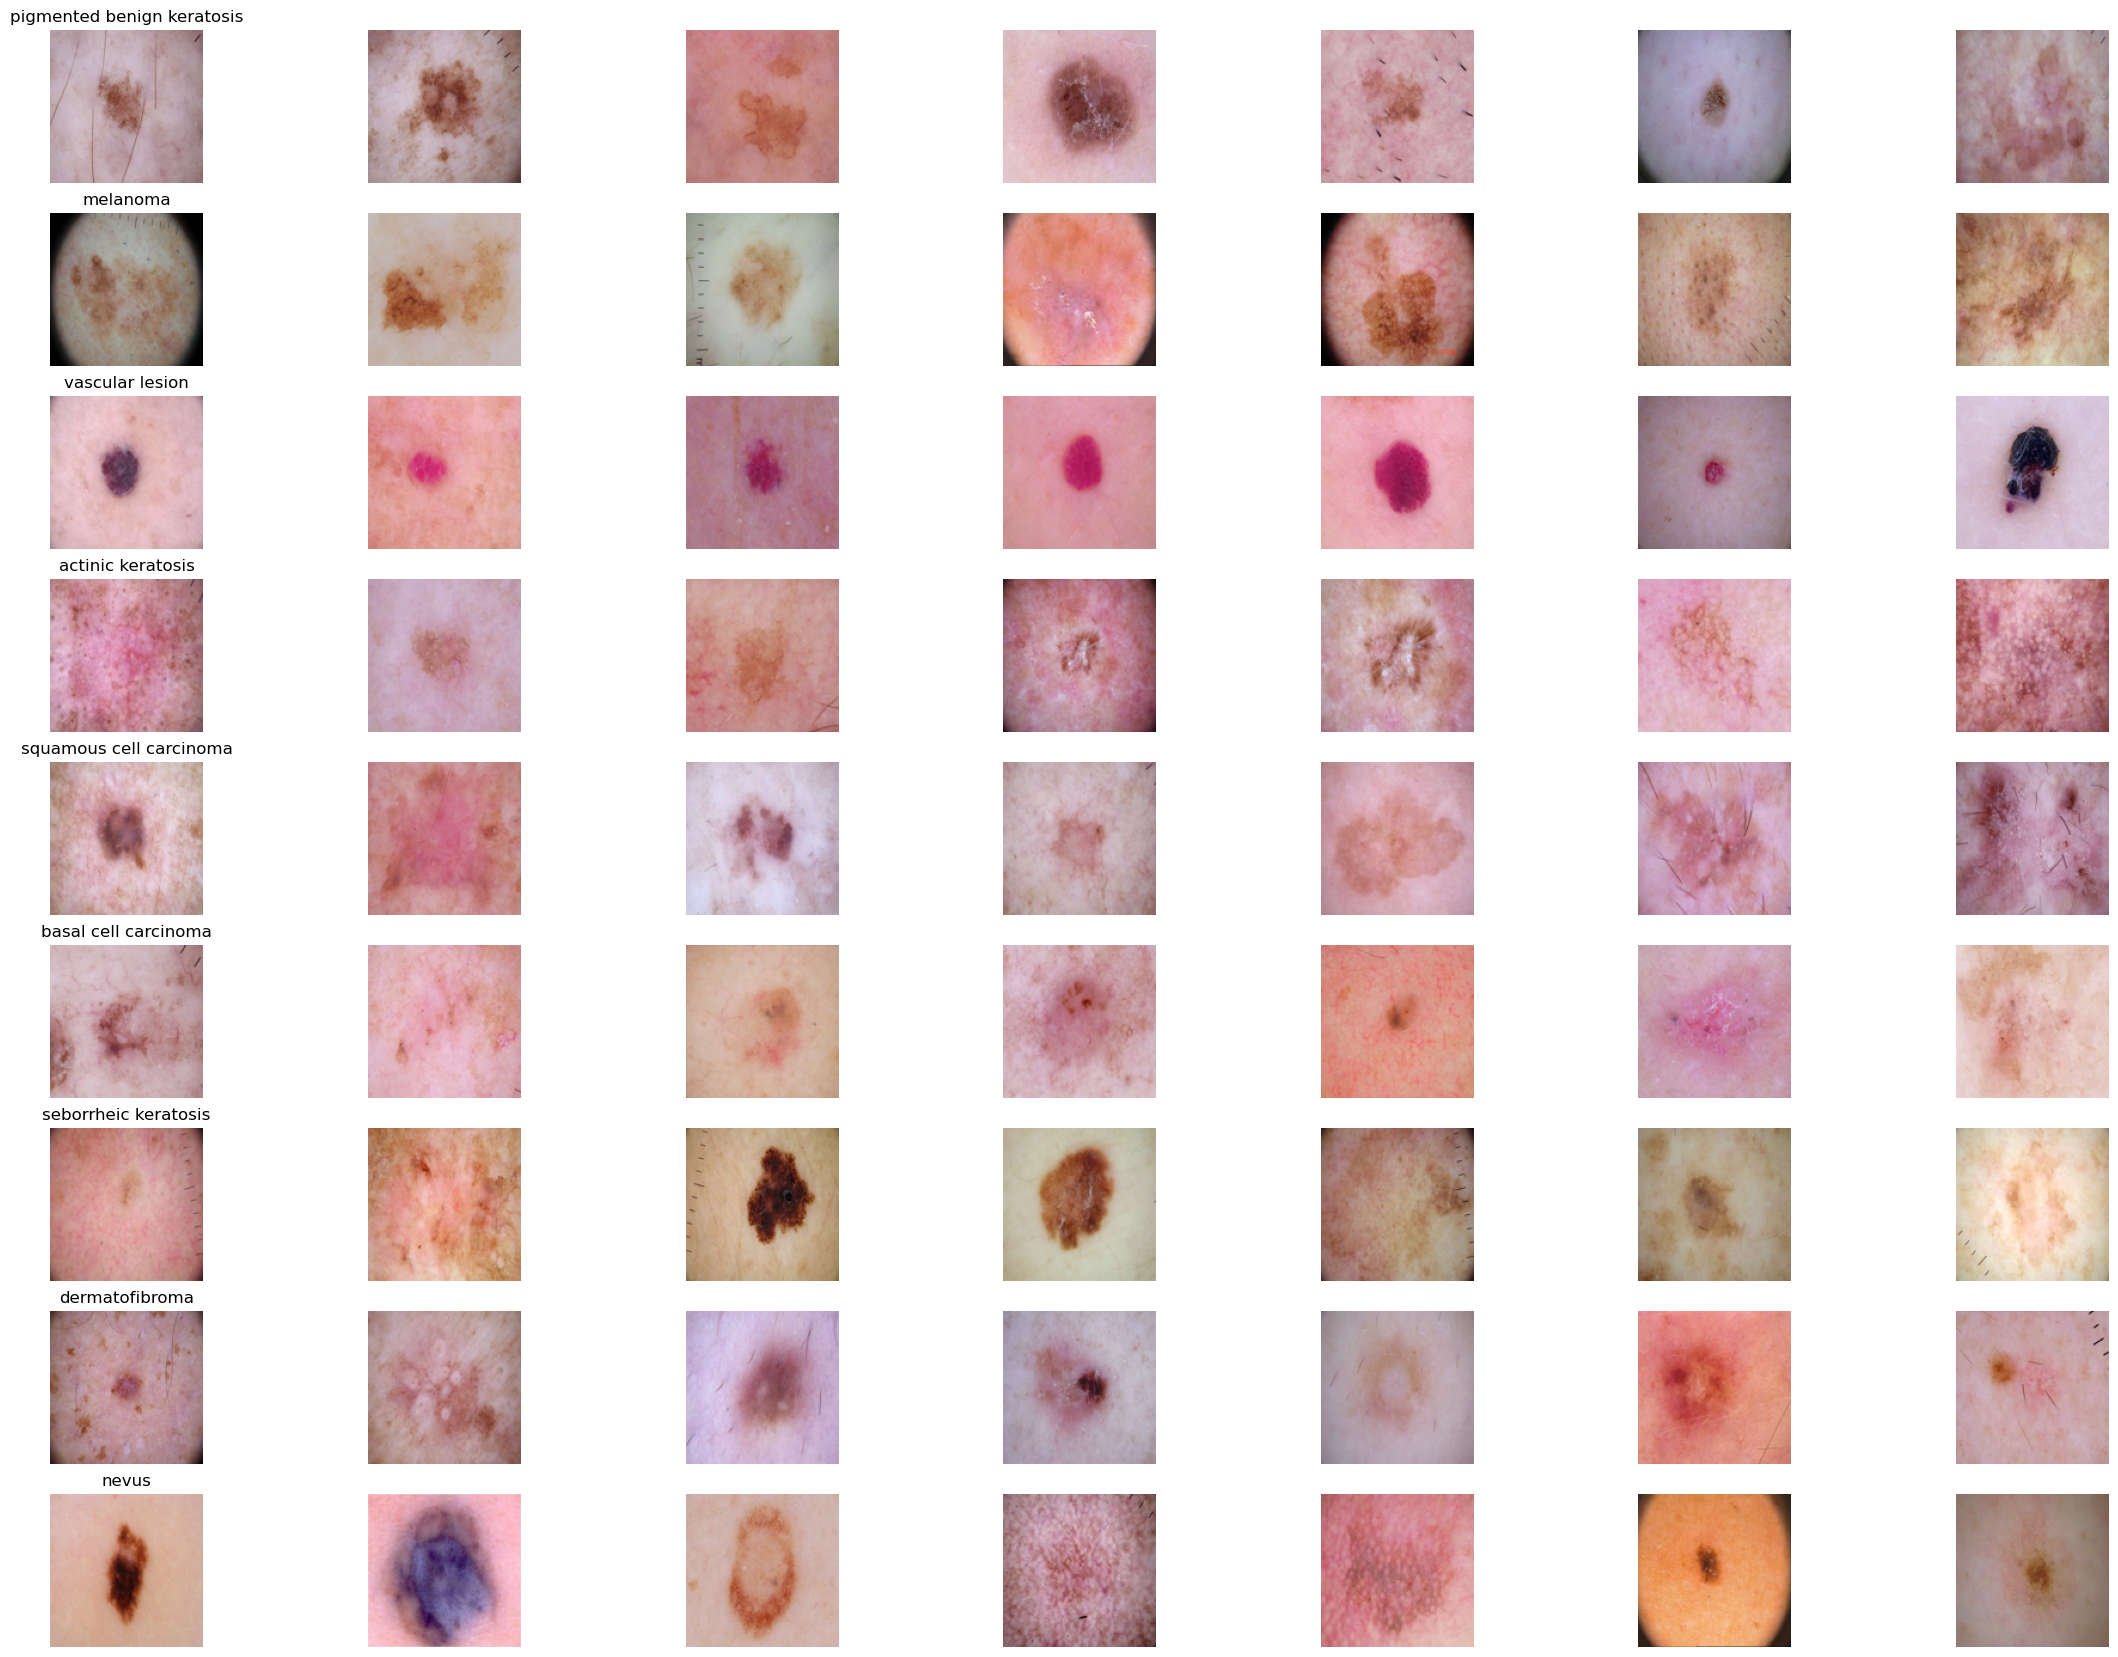

In [13]:
n_samples = 7
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [14]:
df['image'].map(lambda x: x.shape).value_counts()

(128, 128, 3)    2239
Name: image, dtype: int64

# Step 5 : Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly translate images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Randomly translate images vertically by up to 20% of the height
    shear_range=0.2,            # Apply shear transformations with a shear intensity of 0.2
    zoom_range=0.2,             # Randomly zoom in on images by up to 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Filling in newly created pixels after a transformation (nearest neighbor)
)


In [16]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

> # Displaying the total number of images of each Class after Data Augmentation

In [17]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     3000      
1               melanoma                       3000      
2               vascular lesion                3000      
3               actinic keratosis              3000      
4               squamous cell carcinoma        3000      
5               basal cell carcinoma           3000      
6               seborrheic keratosis           3000      
7               dermatofibroma                 3000      
8               nevus                          3000      
------------------------------------------------------------
Total                                         27000     


# Step 6 : Train and Test split

In [18]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [19]:
features.head()

,image
0,"[[[173, 171, 149], [174, 169, 143], [174, 166,..."
1,"[[[247, 238, 230], [246, 238, 229], [246, 238,..."
2,"[[[223, 195, 204], [224, 197, 206], [224, 195,..."
3,"[[[159, 118, 127], [159, 118, 127], [160, 119,..."
4,"[[[217, 168, 184], [217, 170, 186], [218, 170,..."


In [20]:
target.head()

0    1
1    6
2    2
3    5
4    3
Name: label, dtype: object

In [21]:
print(target.shape,features.shape)

(27000,) (27000, 1)


In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [23]:
print(type(x_train), type(y_train))
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>
(21600, 1) (21600,)
(5400, 1) (5400,)


# Step 7 : Normalization of Data

In [24]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Step 8 : Label Encoding

In [25]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

In [26]:
y_train.shape
x_train.shape

(21600, 128, 128, 3)

# Step 9 : Splitting the data into training and Validation Split

In [28]:
# Reshape image in 3 dimensions (height = 128px, width = 128px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(128, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(128, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(128, 128, 3))

In [29]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [30]:
x_train.shape, y_train.shape

((17280, 128, 128, 3), (17280, 9))

> # Displaying the total number of images of each Class

In [31]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1923       467          610        3000      
1               melanoma                       1916       474          610        3000      
2               vascular lesion                1918       470          612        3000      
3               actinic keratosis              1952       471          577        3000      
4               squamous cell carcinoma        1899       498          603        3000      
5               basal cell carcinoma           1910       482          608        3000      
6               seborrheic keratosis           1912       501          587        3000      
7               dermatofibroma                 1924       

In [32]:
df.groupby('label').size()

label
0    3000
1    3000
2    3000
3    3000
4    3000
5    3000
6    3000
7    3000
8    3000
dtype: int64

In [33]:
input_shape = df['image'][0].shape
input_shape

(128, 128, 3)

# Step 10 : Model Architecture

**DenseNet121**

In [34]:
# from tensorflow.keras.applications import DenseNet201
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # Load the base VGG16 model without the top layers
# vgg16_base = DenseNet201(include_top=False, weights=None, input_shape=input_shape)

# # Load pre-trained weights manually if needed
# vgg16_base.load_weights('/kaggle/input/densenet/tensorflow2/default/1/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5')

# # Create a new Sequential model
# model = Sequential()

# # Add the VGG16 base model
# model.add(vgg16_base)

# # Add custom layers on top of the VGG16 base
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add another Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# # Print the model summary
# model.summary()


**MobileNet**

In [35]:
# from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # MobileNet
# model = Sequential()
# model.add(MobileNet(include_top=False, weights='imagenet', input_shape=input_shape))
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()


**VGG16**

In [36]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # Load the base VGG16 model without the top layers
# vgg16_base = VGG16(include_top=False, weights=None, input_shape=input_shape)

# # Load pre-trained weights manually if needed
# vgg16_base.load_weights('/kaggle/input/vgg-16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# # Create a new Sequential model
# model = Sequential()

# # Add the VGG16 base model
# model.add(vgg16_base)

# # Add custom layers on top of the VGG16 base
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add another Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# # Print the model summary
# model.summary()


**VGG19**

In [37]:
# from tensorflow.keras.applications.vgg19 import VGG19
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # VGG19
# model = Sequential()
# model.add(VGG19(include_top=False, weights='imagenet', input_shape=input_shape))
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()


**ResNet101**

In [38]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Define the number of classes
num_classes = 9  # Adjust this based on your specific dataset

# Define the input shape
input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# ResNet101
model = Sequential()
model.add(ResNet101(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                       

**Xception**

In [39]:
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # Load the base VGG16 model without the top layers
# vgg16_base = Xception(include_top=False, weights=None, input_shape=input_shape)

# # Load pre-trained weights manually if needed
# vgg16_base.load_weights('/kaggle/input/xception/tensorflow2/default/1/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# # Create a new Sequential model
# model = Sequential()

# # Add the VGG16 base model
# model.add(vgg16_base)

# # Add custom layers on top of the VGG16 base
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add another Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# # Print the model summary
# model.summary()


**InceptionV3**

In [40]:
# from tensorflow.keras.applications import InceptionV3
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # Adjust this based on your specific dataset

# # InceptionV3
# model = Sequential()
# model.add(InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape))
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add another Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()


**EfficientNetB0**

In [41]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten, Dropout

# # Define the number of classes
# num_classes = 9  # Adjust this based on your specific dataset

# # Define the input shape
# input_shape = (128, 128, 3)  # EfficientNet usually uses a larger input size, consider resizing if necessary

# # EfficientNetB0
# model = Sequential()
# model.add(EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape))
# model.add(Flatten())
# model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))  # Add another Dropout layer with a dropout rate of 0.5
# model.add(Dense(512, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

# model.summary()


# Step 11 : Setting Optimizer

In [42]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# Step 12: Fitting of model

In [43]:
import time
start = time.time()

# Fit the model
epochs = 50
batch_size = 32
history = model.fit(x=x_train, y=y_train,
                    epochs=epochs, batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

end = time.time()
print(f"Training time: {(end - start)/60:.4f} (mins)")

Epoch 1/50
540/540 [==============================] - 140s 227ms/step - loss: 1.4304 - accuracy: 0.5296 - val_loss: 2.0773 - val_accuracy: 0.2190 - lr: 0.0010
Epoch 2/50
540/540 [==============================] - 120s 223ms/step - loss: 0.7243 - accuracy: 0.7278 - val_loss: 0.5785 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 3/50
540/540 [==============================] - 120s 223ms/step - loss: 0.4682 - accuracy: 0.8249 - val_loss: 0.4588 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 4/50
540/540 [==============================] - 121s 224ms/step - loss: 0.3568 - accuracy: 0.8666 - val_loss: 0.3638 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 5/50
540/540 [==============================] - 121s 224ms/step - loss: 0.2648 - accuracy: 0.9007 - val_loss: 0.3197 - val_accuracy: 0.8926 - lr: 0.0010
Epoch 6/50
540/540 [==============================] - 121s 223ms/step - loss: 0.2190 - accuracy: 0.9182 - val_loss: 0.2900 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 7/50
540/540 [==========================

**Accuracy and Loss Ghraph**

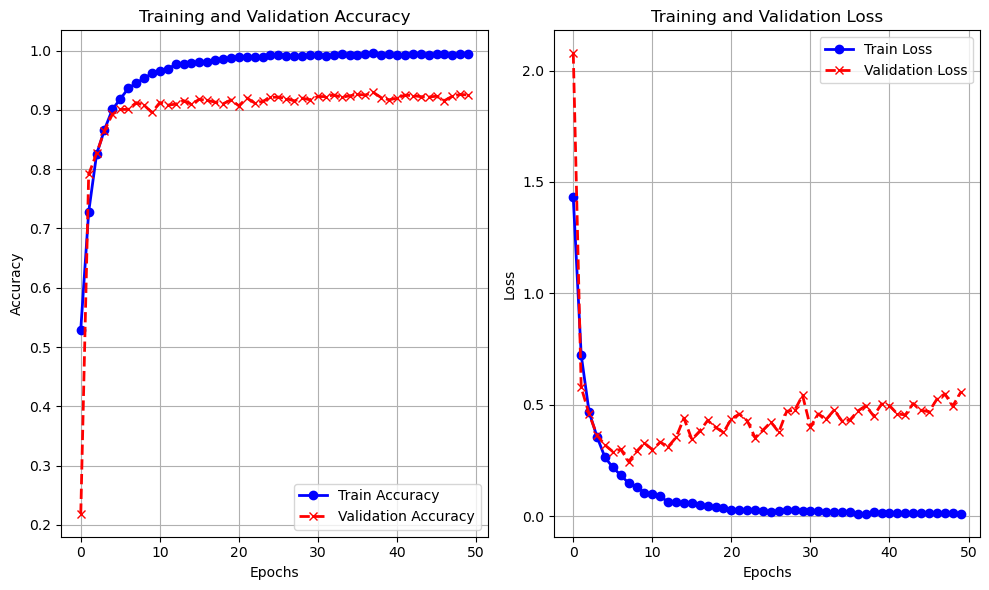

In [44]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs
epochs = range(len(acc))

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', color='b', marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, val_acc, label='Validation Accuracy', color='r', marker='x', linestyle='--', linewidth=2)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', color='b', marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', color='r', marker='x', linestyle='--', linewidth=2)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
# Save the plot to the specified directory
plt.savefig('/kaggle/working/acc_loss_graph.png')
plt.show()


135/135 [==============================] - 10s 57ms/step


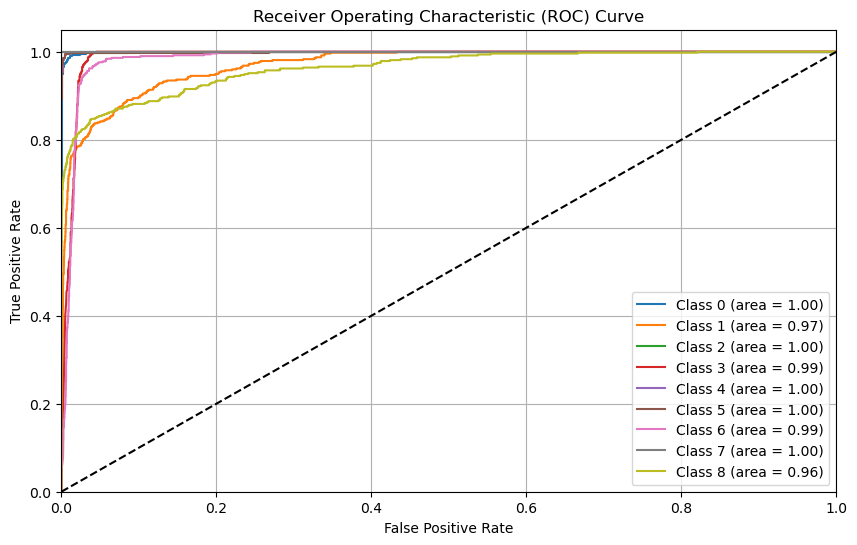

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Predict probabilities for the validation set
y_pred_prob = model.predict(x_validate)

# Binarize the labels for multi-class classification
y_validate_bin = label_binarize(y_validate, classes=np.arange(num_classes))

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validate_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
# Save the plot to the specified directory
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()


# Step 13 : Model Evaluation

**Train and Test Accuracy**

In [46]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

540/540 [==============================] - 32s 59ms/step - loss: 0.0057 - accuracy: 0.9967
Train: accuracy = 0.996701  ;  loss = 0.005738


In [47]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

169/169 [==============================] - 13s 63ms/step - loss: 0.4973 - accuracy: 0.9302
Testing: accuracy = 0.930185  ;  loss = 0.497331


**Normalized Confusion Matrix**

169/169 [==============================] - 12s 57ms/step


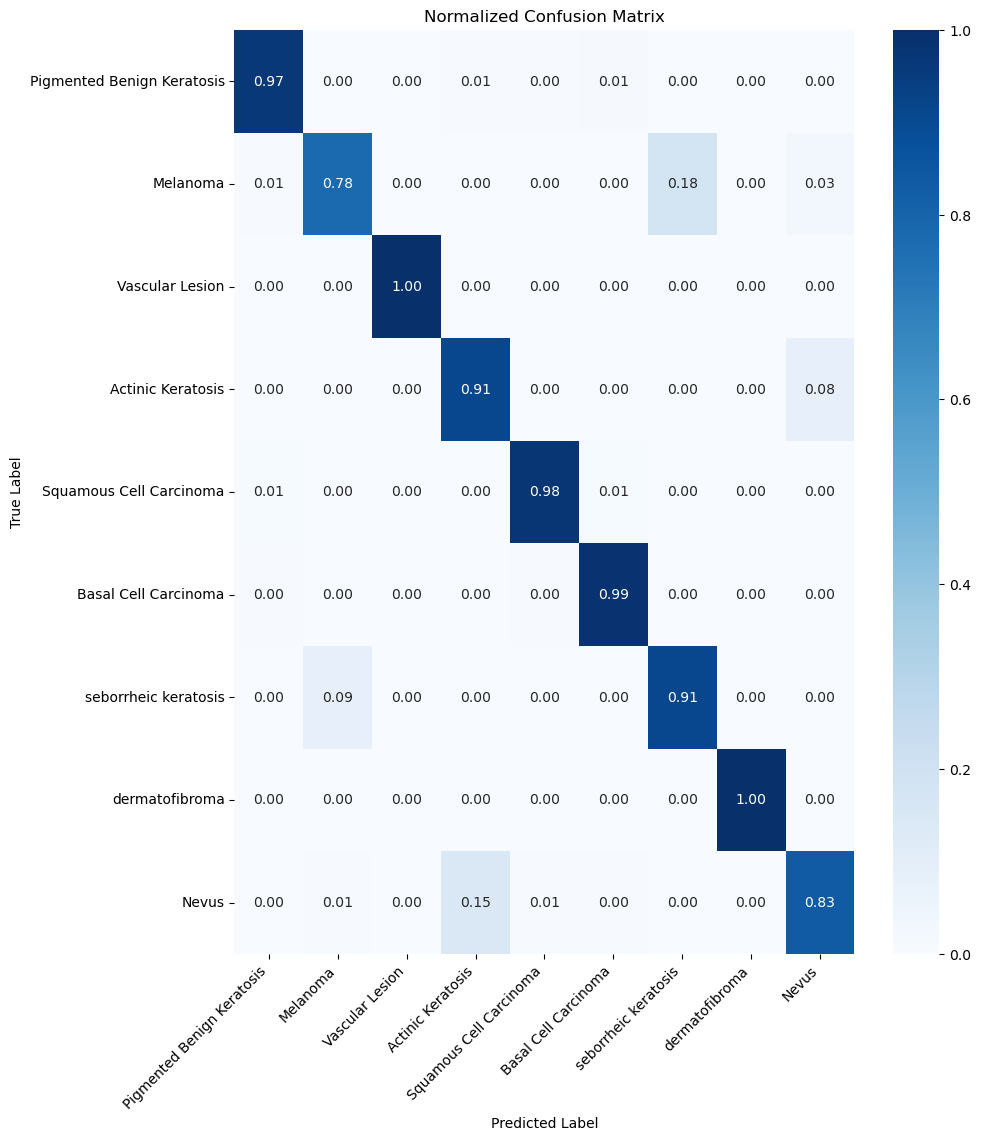

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Provided class names
class_names = [
    'Pigmented Benign Keratosis',
    'Melanoma',
    'Vascular Lesion',
    'Actinic Keratosis',
    'Squamous Cell Carcinoma',
    'Basal Cell Carcinoma',
    'seborrheic keratosis',
    'dermatofibroma',
    'Nevus'
]
# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Save the plot to the specified directory
plt.savefig('/kaggle/working/normalized_confusion_matrix.png')

# Show the plot
plt.show()


**Classification Report (Classwise)**

In [49]:
import numpy as np
from sklearn.metrics import classification_report

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the true labels
y_true = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

# Print the classification report
print("Classification Report:\n")
print(report)


169/169 [==============================] - 10s 57ms/step
Classification Report:

                            precision    recall  f1-score   support

Pigmented Benign Keratosis     0.9768    0.9672    0.9720       610
                  Melanoma     0.8931    0.7803    0.8329       610
           Vascular Lesion     0.9967    1.0000    0.9984       612
         Actinic Keratosis     0.8500    0.9133    0.8805       577
   Squamous Cell Carcinoma     0.9833    0.9784    0.9809       603
      Basal Cell Carcinoma     0.9677    0.9852    0.9764       608
      seborrheic keratosis     0.8297    0.9131    0.8694       587
            dermatofibroma     0.9966    1.0000    0.9983       591
                     Nevus     0.8792    0.8339    0.8559       602

                  accuracy                         0.9302      5400
                 macro avg     0.9304    0.9302    0.9294      5400
              weighted avg     0.9311    0.9302    0.9298      5400



**Results**

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9302
Precision: 0.9304
Recall: 0.9302
F1-score: 0.9294
Kappa score: 0.9215


# Step 14 : Saving the model

In [51]:
model.save("SkinCancer.h5")

In [52]:
#Generate Download Link
from IPython.display import FileLink
FileLink(r'SkinCancer.h5')

/kaggle/working/SkinCancer.h5

In [53]:
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/SkinCancer.h5')

In [54]:
# Print the full model architecture including input shape
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 9)                 4

In [55]:
# Get input shape from the input layer
print(model1.layers[0].input_shape)


(None, 128, 128, 3)
